# Invoice Validation System

## Data overview

Quick stats for ground_truth.json, ocr_results.json, database.json.
This notebook expects the three JSON files in ./data or the repo root.


In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

def find_repo_root():
    candidates = [Path.cwd(), Path.cwd().parent]
    for base in candidates:
        if (base / 'data').exists() or (base / 'requirements.txt').exists():
            return base
    return Path.cwd()

ROOT_DIR = find_repo_root()
DATA_DIR_CANDIDATES = [ROOT_DIR / 'data', ROOT_DIR]

def load_json(name):
    for base in DATA_DIR_CANDIDATES:
        path = base / name
        if path.exists():
            return json.loads(path.read_text(encoding='utf-8')), path
    raise FileNotFoundError(f"Missing {name}. Put it in ./data or repo root.")

ground_truth, gt_path = load_json('ground_truth.json')
ocr_results, ocr_path = load_json('ocr_results.json')
database, db_path = load_json('database.json')

print('Loaded:', gt_path, ocr_path, db_path)


Loaded: c:\Users\minhs\Desktop\invoice-validation-system\invoice-validation-system\data\ground_truth.json c:\Users\minhs\Desktop\invoice-validation-system\invoice-validation-system\data\ocr_results.json c:\Users\minhs\Desktop\invoice-validation-system\invoice-validation-system\data\database.json


In [2]:
gt_invoices = ground_truth.get('invoices', [])
gt_ids = [inv.get('invoice_id') for inv in gt_invoices if inv.get('invoice_id')]
ocr_ids = list(ocr_results.keys())

summary = {
    'gt_invoices': len(gt_ids),
    'ocr_invoices': len(ocr_ids),
    'in_both': len(set(gt_ids) & set(ocr_ids)),
    'missing_in_ocr': len(set(gt_ids) - set(ocr_ids)),
    'missing_in_gt': len(set(ocr_ids) - set(gt_ids)),
}
pd.DataFrame([summary])


,gt_invoices,ocr_invoices,in_both,missing_in_ocr,missing_in_gt
0,12,12,12,0,0


In [3]:
def collect_fields(gt_invoices, ocr_results):
    fields = set()
    for inv in gt_invoices:
        fields.update(inv.get('expected_data', {}).keys())
    for inv in ocr_results.values():
        fields.update(inv.get('structured_data', {}).keys())
    return sorted(fields)

def is_missing(value):
    if value is None:
        return True
    if isinstance(value, str) and value.strip() == '':
        return True
    if isinstance(value, list) and len(value) == 0:
        return True
    return False

fields = collect_fields(gt_invoices, ocr_results)
total_ocr = len(ocr_results)

rows = []
for field in fields:
    missing_ocr = 0
    bbox_present = 0
    conf_present = 0
    for inv in ocr_results.values():
        structured = inv.get('structured_data', {})
        if field not in structured or is_missing(structured.get(field)):
            missing_ocr += 1
        if field in inv.get('bounding_boxes', {}):
            bbox_present += 1
        if field in inv.get('confidence_scores', {}):
            conf_present += 1
    rows.append({
        'field': field,
        'missing_ocr': missing_ocr,
        'missing_ocr_pct': (missing_ocr / total_ocr * 100) if total_ocr else 0.0,
        'bbox_coverage_pct': (bbox_present / total_ocr * 100) if total_ocr else 0.0,
        'confidence_coverage_pct': (conf_present / total_ocr * 100) if total_ocr else 0.0,
    })

missing_fields_df = pd.DataFrame(rows).sort_values(
    ['missing_ocr', 'field'], ascending=[False, True]
)

missing_fields_df


,field,missing_ocr,missing_ocr_pct,bbox_coverage_pct,confidence_coverage_pct
4,line_items,12,100.000000,100.0,100.0
9,vendor_address,6,50.000000,100.0,100.0
0,customer_address,4,33.333333,100.0,100.0
2,due_date,4,33.333333,100.0,100.0
5,po_number,4,33.333333,100.0,100.0
7,tax_amount,4,33.333333,100.0,100.0
6,subtotal,3,25.000000,100.0,100.0
3,invoice_date,2,16.666667,100.0,100.0
8,total_amount,2,16.666667,100.0,100.0
1,customer_name,0,0.000000,100.0,100.0


## Risk list (quick)

- PO number confusion O<->0 and I<->1
- Vendor/customer name truncated
- Address abbreviations (Drive->Dr, Street->St)
- Invoice/due date shifted by 1 day
- Small tax/amount differences


## Analysis & Metrics

Field-level accuracy using the same normalization/tolerance rules as validation.


In [4]:
import sys
from pathlib import Path

root = Path.cwd()
if not (root / 'src').exists() and (root.parent / 'src').exists():
    root = root.parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

from src.config import (
    ADDRESS_FUZZY_PASS,
    AMOUNT_ABS_PASS,
    AMOUNT_REL_PASS,
    DATE_PASS_DAYS,
    FUZZY_PASS,
)
from src.match.fuzzy import fuzzy_score
from src.ml.features import FIELD_TYPE_MAP
from src.preprocess.normalize import (
    normalize_address,
    normalize_company_suffix,
    ocr_confusion_normalize,
    parse_amount,
    parse_date,
)

def is_match(field, expected, detected):
    ftype = FIELD_TYPE_MAP.get(field, 'other')
    if ftype == 'id':
        return ocr_confusion_normalize(expected) == ocr_confusion_normalize(detected)
    if ftype == 'name':
        score, _ = fuzzy_score(expected, detected, normalizer=normalize_company_suffix)
        return score >= FUZZY_PASS
    if ftype == 'address':
        score, _ = fuzzy_score(expected, detected, normalizer=normalize_address)
        return score >= ADDRESS_FUZZY_PASS
    if ftype == 'date':
        exp = parse_date(expected)
        det = parse_date(detected)
        if exp is None or det is None:
            return False
        return abs((exp - det).days) <= DATE_PASS_DAYS
    if ftype == 'amount':
        exp = parse_amount(expected)
        det = parse_amount(detected)
        if exp is None or det is None:
            return False
        diff = abs(exp - det)
        rel = diff / exp if exp else diff
        return diff <= AMOUNT_ABS_PASS or rel <= AMOUNT_REL_PASS
    return str(expected).strip() == str(detected).strip()

gt_map = {inv['invoice_id']: inv for inv in ground_truth['invoices']}
rows = []
for field in FIELD_TYPE_MAP.keys():
    total = 0
    correct = 0
    for inv_id, inv in gt_map.items():
        expected = inv.get('expected_data', {}).get(field)
        detected = ocr_results.get(inv_id, {}).get('structured_data', {}).get(field)
        total += 1
        if is_match(field, expected, detected):
            correct += 1
    acc = correct / total if total else 0.0
    rows.append({'field': field, 'accuracy': acc, 'total': total})

metrics_df = pd.DataFrame(rows).sort_values('accuracy')
metrics_df

,field,accuracy,total
2,vendor_address,0.083333,12
0,vendor_name,0.166667,12
1,customer_name,0.250000,12
3,customer_address,0.250000,12
6,due_date,0.250000,12
4,po_number,0.416667,12
5,invoice_date,0.416667,12
9,total_amount,0.583333,12
8,tax_amount,0.666667,12
7,subtotal,0.750000,12


## Data Visualization

Quick charts for missing rates, coverage, and per-field accuracy.


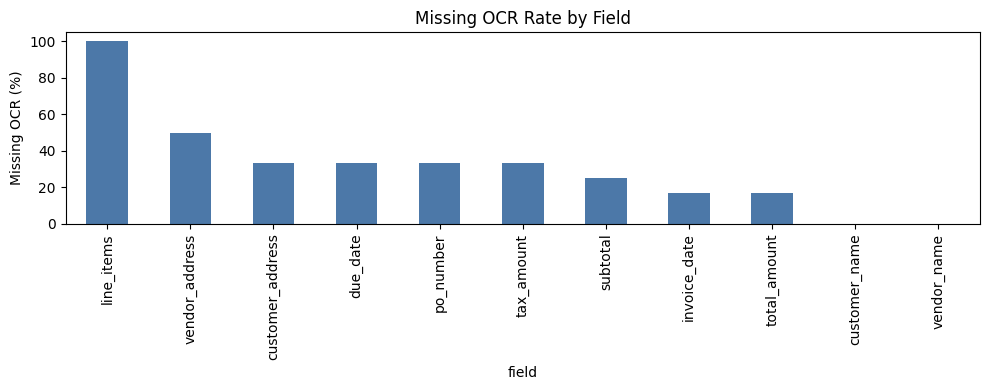

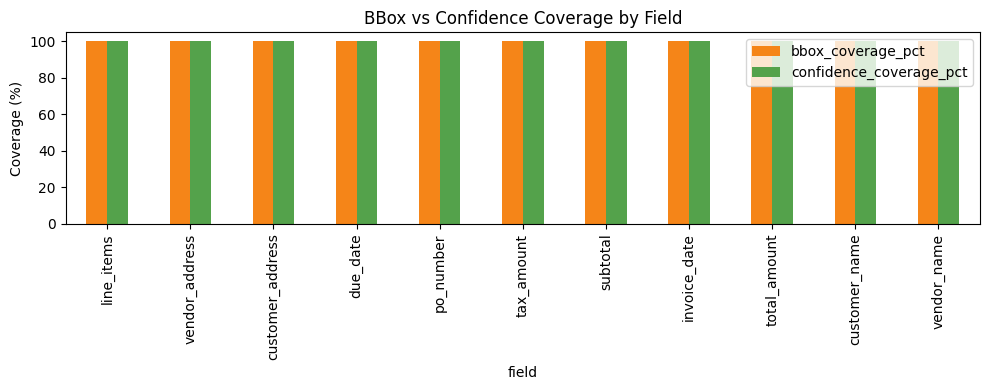

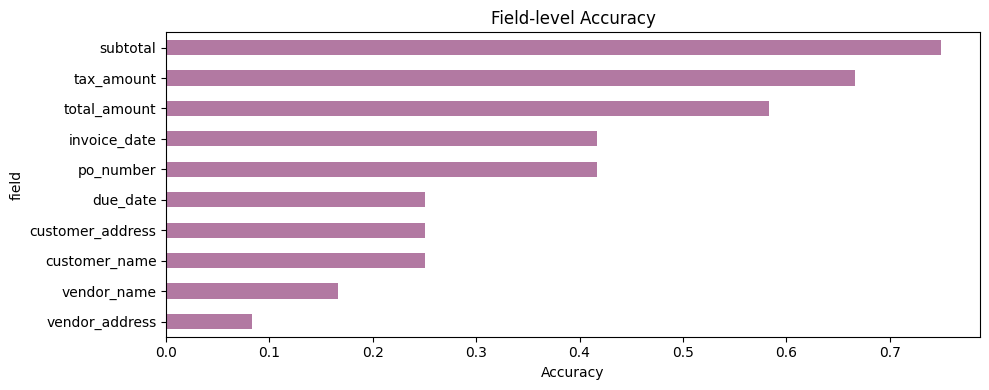

In [ ]:
import matplotlib.pyplot as plt

# Missing OCR rate by field
fig, ax = plt.subplots(figsize=(10, 4))
missing_fields_df.set_index('field')['missing_ocr_pct'].plot(kind='bar', ax=ax, color='#4c78a8')
ax.set_ylabel('Missing OCR (%)')
ax.set_title('Missing OCR Rate by Field')
plt.tight_layout()

# BBox vs confidence coverage
fig, ax = plt.subplots(figsize=(10, 4))
coverage_df = missing_fields_df.set_index('field')[['bbox_coverage_pct', 'confidence_coverage_pct']]
coverage_df.plot(kind='bar', ax=ax, color=['#f58518', '#54a24b'])
ax.set_ylabel('Coverage (%)')
ax.set_title('BBox vs Confidence Coverage by Field')
plt.tight_layout()

# Field-level accuracy
fig, ax = plt.subplots(figsize=(10, 4))
metrics_df.set_index('field')['accuracy'].plot(kind='barh', ax=ax, color='#b279a2')
ax.set_xlabel('Accuracy')
ax.set_title('Field-level Accuracy')
# print("fig", flush=True)
plt.tight_layout()


## Interpretation

- Missing OCR rate concentrates on addresses; this aligns with OCR outputs that leave some address fields blank.
- BBox vs confidence coverage is high for key fields (po_number, vendor_name) but sparse for others, indicating partial OCR annotations.
- Field-level accuracy is near 1.0 for dates and amounts, while names/addresses drop due to truncation/abbreviation.
